In [38]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json

In [97]:

#This preference table is the basis for generating the graph
class pref_table():

  def __init__(self, parents, childName, childDomain, table):
    self.parents = parents
    self.childName = childName
    self.childDomain = childDomain
    self.table = table
  
  def print_table(self):
    print(self.table)

#This converts an array of preference tables into a CPNetwork
def convert_tables(tables):
  g = nx.DiGraph()
  for tb in tables:
    g.add_node(tb.childName, p_order=tb.parents, tab=tb.table, dom=tb.childDomain)
  for tb in tables:
    for p in tb.parents:
      g.add_edge(p, tb.childName)
  return g

def make_assignment_graph(cpnet):
  g = nx.DiGraph()

  dic_list = [{}]
  for nod in cpnet.nodes():
    splitter = []
    for d in dic_list:
      for ass in range(len(cpnet.nodes[nod]['dom'])):
        hold = d.copy()
        hold[nod] = ass
        splitter.append(hold)
    dic_list = splitter
  
  for d in dic_list:
    g.add_node(json.dumps(d), ass=d)

  for x in g.nodes():
    for cpnode, assign in g.nodes[x]['ass'].items():
      #This section needs to change if we aren't doing binary prefs
      p_ass = []
      for p in cpnet.nodes[cpnode]['p_order']:
        p_ass.append(g.nodes[x]['ass'][p])
      best_val = get_best_assignment(p_ass, cpnet.nodes[cpnode]['tab'])
      if assign == best_val:
        for other_ass in range(len(cpnet.nodes[cpnode]['dom'])):
          if not(other_ass == assign):
            hold = g.nodes[x]['ass'].copy()
            hold[cpnode] = other_ass
            g.add_edge(json.dumps(hold), x)
  return g

#This takes a CPNetwork and displays it
def display_g(graph):
  pos = nx.spring_layout(graph)
  nx.draw(graph, pos) 
  nx.draw_networkx_labels(graph, pos)
  plt.show()

#This take a CPNetwork and tells you what the best assignment is
def get_best(graph):
  res_dic = {}
  queue = find_roots(graph)
  hold_dic = {}
  while len(queue) != 0:
    assign = queue.pop()
    p_ass = []
    for p in graph.nodes[assign]['p_order']:
      p_ass.append(res_dic[p])
    res_dic[assign] = get_best_assignment(p_ass, graph.nodes[assign]['tab'])
    for child in graph.neighbors(assign):
      if child in hold_dic.keys():
        hold_dic[child].append(assign)
      else:
        hold_dic[child] = [assign]
      if len(hold_dic[child]) >= len(graph.nodes[child]['p_order']):
        queue.append(child)
  return res_dic

# This takes an assignment of integers and converts them into 
# the value name listed in the domain of each node
def convert_ass(graph, ass):
  for nod in graph.nodes():
    ass[nod] = graph.nodes[nod]['dom'][ass[nod]]
  return ass

# If you give a set of parent assignments and an assignment table,
# This function gives you the best assignment for that value
def get_best_assignment(p_assign, ass_table):
  for p in p_assign:
    ass_table = ass_table[p]
  if type(ass_table) is np.ndarray:
    ass_table = ass_table.item()
  return ass_table

# A helper function that grabs the roots of the CPNetwork
def find_roots(graph):
  hold = []
  ordering = list(nx.topological_sort(graph))
  for o in ordering:
    if len(graph.nodes[o]['p_order']) == 0:
      hold.append(o)
  return hold

#Generates a dictionary that 
def make_parent_table(graph):
  res_dic = {}
  for nod in graph.nodes:
    for p in graph.nodes[nod]['p_order']:
      if p in res_dic.keys():
        res_dic[p].append(nod)
      else:
        res_dic[p] = [nod]
  return res_dic



table 2


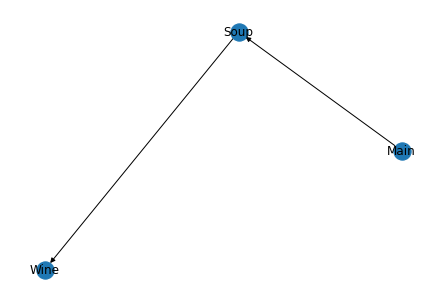

{'Main': 'Meat', 'Soup': 'Fish', 'Wine': 'White'}


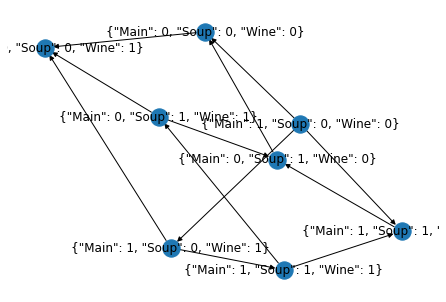

table 2


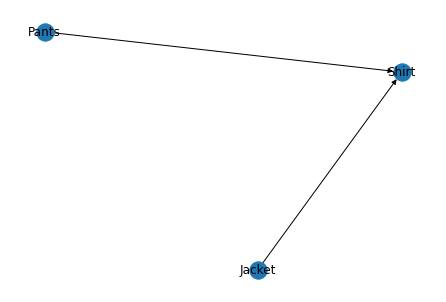

{'Pants': 'Blue', 'Jacket': 'Blue', 'Shirt': 'White'}


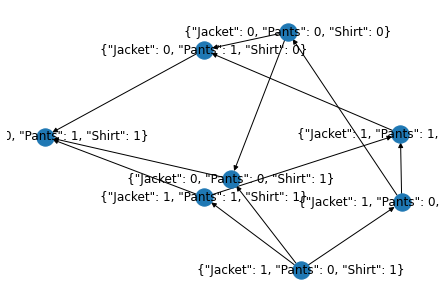

In [117]:
dinner_tables = []

parents = []
childName = 'Main'
childDomain = ('Meat', 'Fish')
table = np.array(0)
dinner_tables.append(pref_table(parents, childName, childDomain, table))

parents = ['Main']
childName = 'Soup'
childDomain = ('Fish', 'Veg')
table = np.array([0, 1])
dinner_tables.append(pref_table(parents, childName, childDomain, table))

parents = ['Soup']
childName = 'Wine'
childDomain = ('Red', 'White')
table = np.array([1, 0])
dinner_tables.append(pref_table(parents, childName, childDomain, table))

hold = convert_tables(dinner_tables)
print("table 2")
display_g(hold)
print(convert_ass(hold, get_best(hold)))
display_g(make_assignment_graph(hold))

getting_ready_tables = []

parents = []
childName = 'Jacket'
childDomain = ('Blue', 'White')
table = np.array(0)
getting_ready_tables.append(pref_table(parents, childName, childDomain, table))

parents = []
childName = 'Pants'
childDomain = ('White', 'Blue')
table = np.array(1)
getting_ready_tables.append(pref_table(parents, childName, childDomain, table))

parents = ['Pants', 'Jacket']
childName = 'Shirt'
childDomain = ('Red', 'White')
table = np.array([[1, 0], [1, 0]])
getting_ready_tables.append(pref_table(parents, childName, childDomain, table))

hold = convert_tables(getting_ready_tables)
print("table 2")
display_g(hold)
print(convert_ass(hold, get_best(hold)))
pref_graph = make_assignment_graph(hold)
display_g(pref_graph)

In [115]:
def flipTestADominatesB(assignA, assignB, prefGraph):
  queue = [assignA]
  while len(queue) != 0:
    node = queue.pop()
    if node == assignB:
      return False
    for child in prefGraph.neighbors(node):
      queue.append(child)
  return True

def decHeursTestABetterB(assignA, assignB, prefGraph):
  return (decHeuristic(assignA, prefGraph) < decHeuristic(assignB, prefGraph))

def decHeuristic(assign, prefGraph):
  desc = 0
  queue = [assign]
  while len(queue) != 0:
    node = queue.pop()
    for child in prefGraph.neighbors(node):
      queue.append(child)
      desc += 1
  return desc

In [116]:
assignA = json.dumps({"Jacket": 1, "Pants": 1, "Shirt": 1})
assignB = json.dumps({"Jacket": 1, "Pants": 1, "Shirt": 0})

print(decHeuristic(assignA, pref_graph))
print(decHeuristic(assignB, pref_graph))

print(flipTestADominatesB(assignA, assignB, pref_graph))
print(decHeursTestABetterB(assignA, assignB, pref_graph))

4
2
False
False
